In [56]:
from IPython.display import Image
%matplotlib inline

# 主成分分析实现无监督降维

先看：[【中字】主成分分析法（PCA）| 分步步骤解析 看完你就懂了！](https://www.bilibili.com/video/BV1C7411A7bj)

再看：[用最直观的方式告诉你：什么是主成分分析PCA](https://www.bilibili.com/video/BV1E5411E71z)

与特征选择类似，我们可以用不同的特征提取技术来减少数据集的特征数量。特征选择和特征提取的区别在于，当我们用诸如逆序选择之类的**特征选择**算法时，数据集的**原始特征保持不变**，而当我们用**特征提取**方法时，会**将数据变换或投影到新特征空间**。

在降维的背景下，我们可以把特征提取理解为数据压缩的一种方法，其目的是保持大部分的相关信息。在实际应用中，特征提取不仅可以优化存储空间或机器学习算法的计算效率，而且还可以通过减少维数诅咒提高预测性能，尤其是当我们处理非正则化模型的时候。

## 主成分分析的主要步骤

PCA旨在寻找高维数据中存在最大方差的方向，并将数据投影到维数小于或等于原始数据的新子空间。

假设新特征轴彼此正交，该空间的正交轴（主成分）可以解释为方差最大的方向，如图所示。其中x1和x2为原始特征轴，而PC1和PC2为主成分方向。

PCA的方向对数据尺度非常敏感，需要在进行PCA之前对特征进行标准化，如果以不同的尺度测量特征值，则需要确保所有特征的重要性保持均衡。

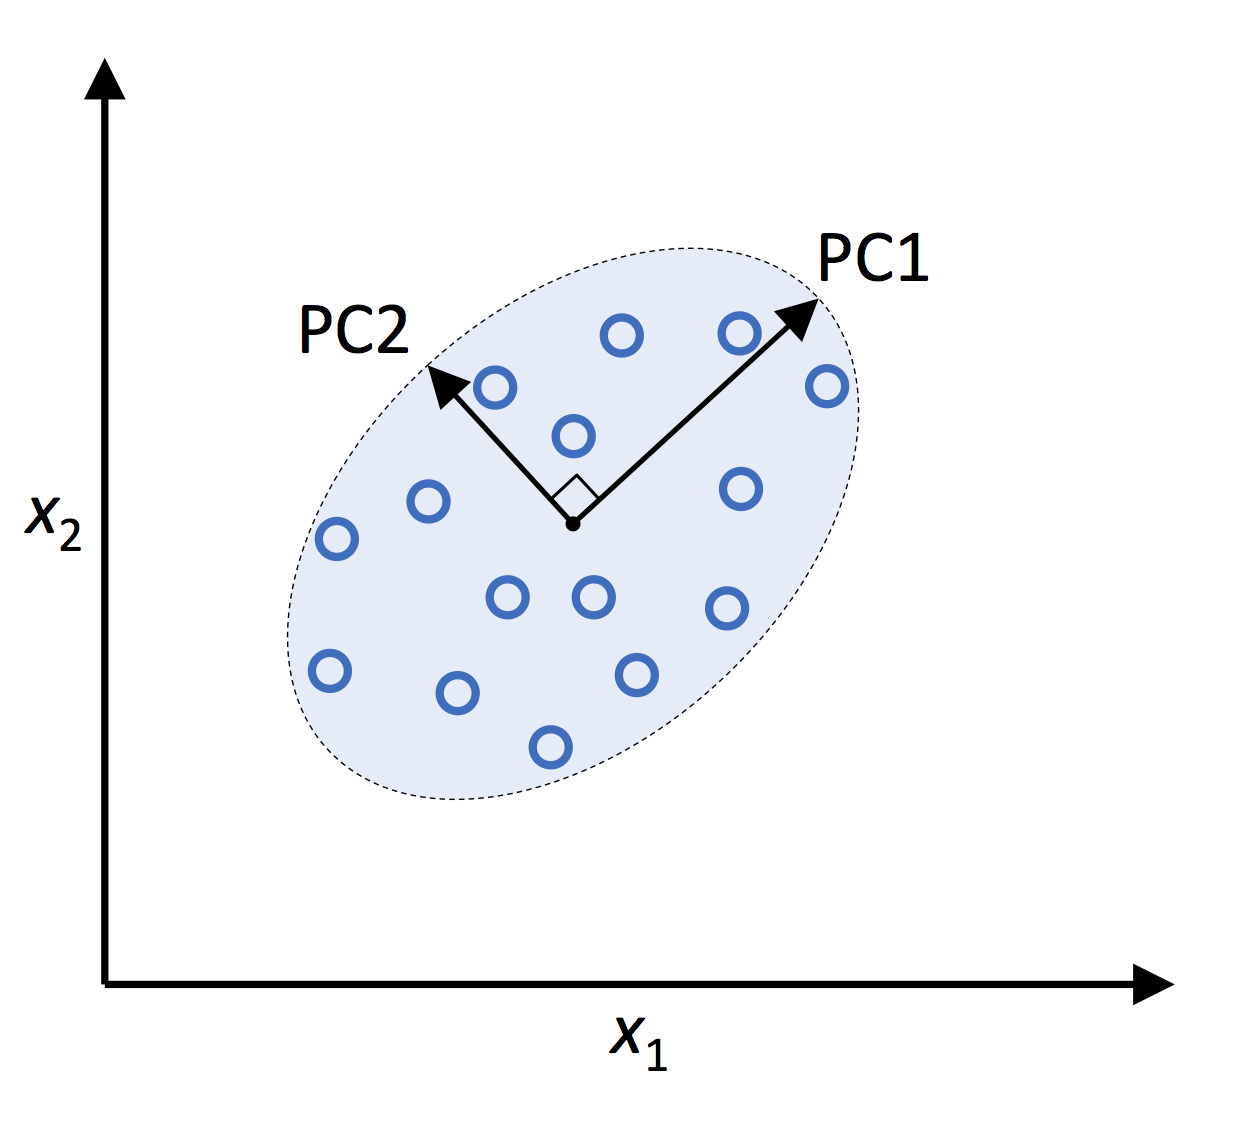

In [57]:
Image(filename='images/05_01.png', width=400) 

讨论PCA降维算法之前，先用几个简单的步骤来概括该方法：
1. 标准化d维数据集。
2. 构建协方差矩阵。
3. 将协方差矩阵分解为特征向量和特征值。
4. 以降序对特征值排序，从而对相应的特征向量排序。
5. 选择对应k个最大特征值的k个特征向量，其中k为新特征子空间的维数（k≤d）。
6. 由前k个特征向量构造投影矩阵W。
7. 用投影矩阵W变换d维输入数据集X以获得新的k维特征子空间。

## 逐步提取主成分

本小节讨论PCA的前四个步骤：
1. 标准化数据集。
2. 构建协方差矩阵。
3. 获取协方差矩阵的特征值和特征向量。
4. 以降序对特征值排序，从而对特征向量排序。

In [58]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


按照7：3的比例，把葡萄酒数据分割成独立的训练数据集和测试数据集

In [59]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

标准化为单位方差：

In [60]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**Note**

Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.

My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.

Let's assume we have a simple training set consisting of 3 examples with 1 feature (let's call this feature "length"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify examples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these examples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation and and mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify examples 4 and 5 as class 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

However, if we use the parameters from your "training set standardization," we'd get the values:

- example5: -18.37 -> class 2
- example6: -17.15 -> class 2
- example7: -15.92 -> class 2

The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new examples" are much lower than every standardized feature in the training set.

---

协方差矩阵的特征向量和特征值：

In [61]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


上面用numpy.cov函数计算标准化的训练数据集的协方差矩阵。用 [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) 函数完成特征分解，
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
这不能说是错误，而只是一个次优解。`numpy.linalg.eig` 函数可以处理对称和非对称方阵操作。但是你可能会发现，在某些情况下它会返回复特征值。

[`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) 是一个相关函数，它可以分解埃尔米特矩阵（[Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix)）矩阵，从数值的角度来说，这是一个解决对称矩阵（例如协方差矩阵）的更稳定的方法，`numpy.linalg.eigh` 始终返回实特征值。

结果产生包含13个特征值的向量（eigen_vals），所对应的特征向量存储在13×13维矩阵（eigen_vecs）的列中。

## 总方差和解释方差

我们想要通过将数据集压缩到新特征子空间来降低维数，所以只选择包含最多信息（**方差最大**）的特征向量（主成分）的子集。

特征值代表特征向量的大小，通过对特征值的降序排列，我们可以找出前k个最重要的特征向量。

但是，在收集k个信息最丰富的特征向量之前，我们先把特征值的方差解释比画出来。

In [62]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

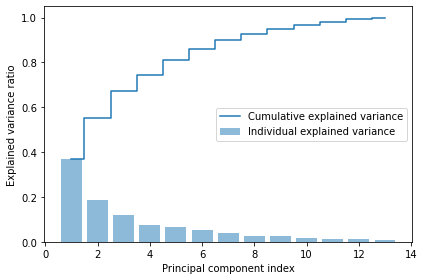

In [63]:
import matplotlib.pyplot as plt

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

结果表明，第一主成分本身占方差的40%左右。此外，我们还可以看到把前两个主成分结合起来可以解释数据集中几乎60%的方差。

解释方差图让我们回想起第4章中通过随机森林计算的特征重要值，但是要注意，
- PCA是一种无监督学习方法，这意味着有关分类标签的信息会被忽略。
- 随机森林用类成员信息计算节点的杂质度，方差测量值沿特征轴的传播。

## 特征变换

把协方差矩阵分解为特征对之后，我们现在接着完成最后的三个步骤（5～7），将葡萄酒数据集变换到新的主成分轴。其余的步骤如下：

5. 选择与前k个最大特征值对应的k个特征向量，其中k为新特征子空间的维数（k≤d）。
6. 用前k个特征向量构建投影矩阵W。
7. 用投影矩阵W变换d维输入数据集X以获得新的k维特征子空间。

通俗地说，我们将把特征对按特征值降序排列，从所选的特征向量构建投影矩阵，用投影矩阵把数据变换到低维子空间。

In [64]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# 把特征对按特征值降序排列
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [65]:
# 收集对应前两个最大特征值的特征向量，从数据集中捕获大约60%的方差。
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


我们在这里只选择两个特征向量来说明问题，因为本小节后面将在二维散点图中绘制数据。在实践中，主成分的数量必须通过计算效率和分类器性能之间的权衡来确定。

**Note**
取决于你所用NumPy和LAPACK的具体版本，得到的矩阵W的正负号可能相反。请注意，这并不是个问题。如果 $v$ 是矩阵 $\Sigma$ 的一个特征向量，那么我们有：

$$\Sigma v = \lambda v,$$

这里 $\lambda$ 为特征向量，而 $-v$ 也是一个特征向量，下面可以证明。用基本代数知识，我们可以在等式的两边乘以标量 $\lambda$：

$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$

用投影矩阵将示例x（表示为13维的行向量）变换到PCA子空间（主成分1和2），从而获得x′，即由两个新特征组成的二维示例向量：

In [66]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

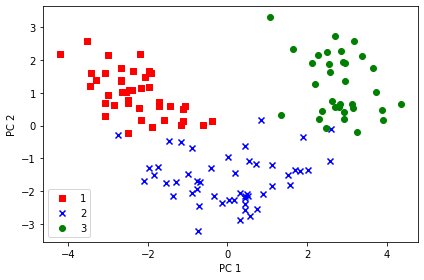

In [67]:
# 通过计算矩阵点积将整个124×13维训练数据集变换成两个主成分
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

把目前存储为124×2维矩阵的葡萄酒训练数据集在二维散点图上完成可视化。

从结果图中我们可以看到，与第二主成分（y轴）相比，数据更多的是沿着x轴（第一主成分）传播，这与前面得出的解释方差比结论一致。然而，这里线性分类器就能够很好地区分不同的类别，

虽然在图中我们对分类标签信息进行了编码，但是必须要记住，PCA是一种**不使用任何分类标签**信息的**无监督学习**技术。

## 用scikit-learn实现主成分分析

PCA是scikit-learn的另一个转换器类，我们首先用训练数据来拟合模型，然后用相同模型参数转换训练数据和测试数据。

**NOTE**

The following four code cells has been added in addition to the content to the book, to illustrate how to replicate the results from our own PCA implementation in scikit-learn:

In [68]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

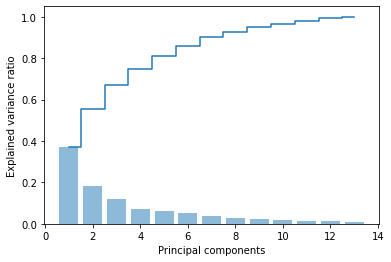

In [69]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [70]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

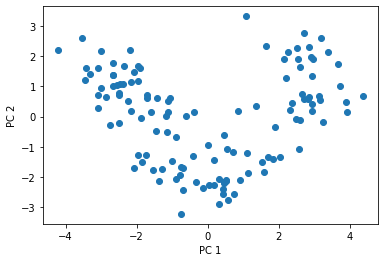

In [71]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [72]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=1, 
                    color=cmap(idx),
                    #edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

用逻辑回归分类模型训练转换后的数据，使用前两个主成分，调用plot_decision_regions函数实现决策区域的可视化。

In [73]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

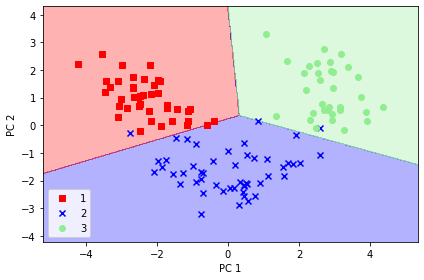

In [74]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

在测试数据集上执行上述代码绘出决策区域之后，我们可以看到逻辑回归在该二维特征子空间上的表现相当不错，

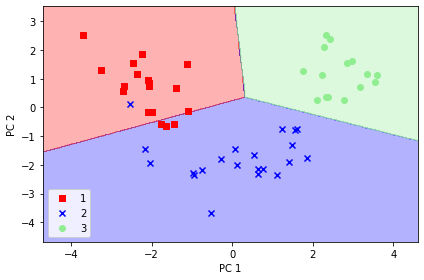

In [75]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

对不同主成分的解释方差比感兴趣，我们可以简单地把参数n_components设置为None来初始化PCA类，这样就可以保留所有的主成分，然后通过调用explained_variance_ratio_属性访问解释方差比：

In [76]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

请注意，当我们初始化PCA类时，设置n_components=None，系统将返回排过序的所有主成分而不是进行降维。

# 基于线性判别分析的监督数据压缩

线性判别分析（LDA）可用于特征提取，以提高计算效率和减少非正则化模型中因维数诅咒而造成的过拟合的概率。LDA背后的基本概念与PCA非常类似，但PCA试图找到数据集中最大方差的正交成分轴，而LDA的目标是寻找可优化类别可分性的特征子空间。

## 主成分分析与线性判别分析

LDA和PCA都是可以用来降低数据集维数的线性变换技术，前者是无监督学习算法，后者是监督学习算法。因此，有人可能直观地认为LDA是比PCA更优越的用于分类任务的特征提取技术。然而在某些情况下，例如每类只包含少量的样本时，用PCA预处理往往会在图像识别中有更好的分类结果。

LDA假设数据呈正态分布。此外，假设类具有相同的协方差矩阵，并且这些训练样本在统计上彼此独立。然而，即使（略微）违反其中一个或多个假设，用于降维的LDA仍然可以很好地发挥作用

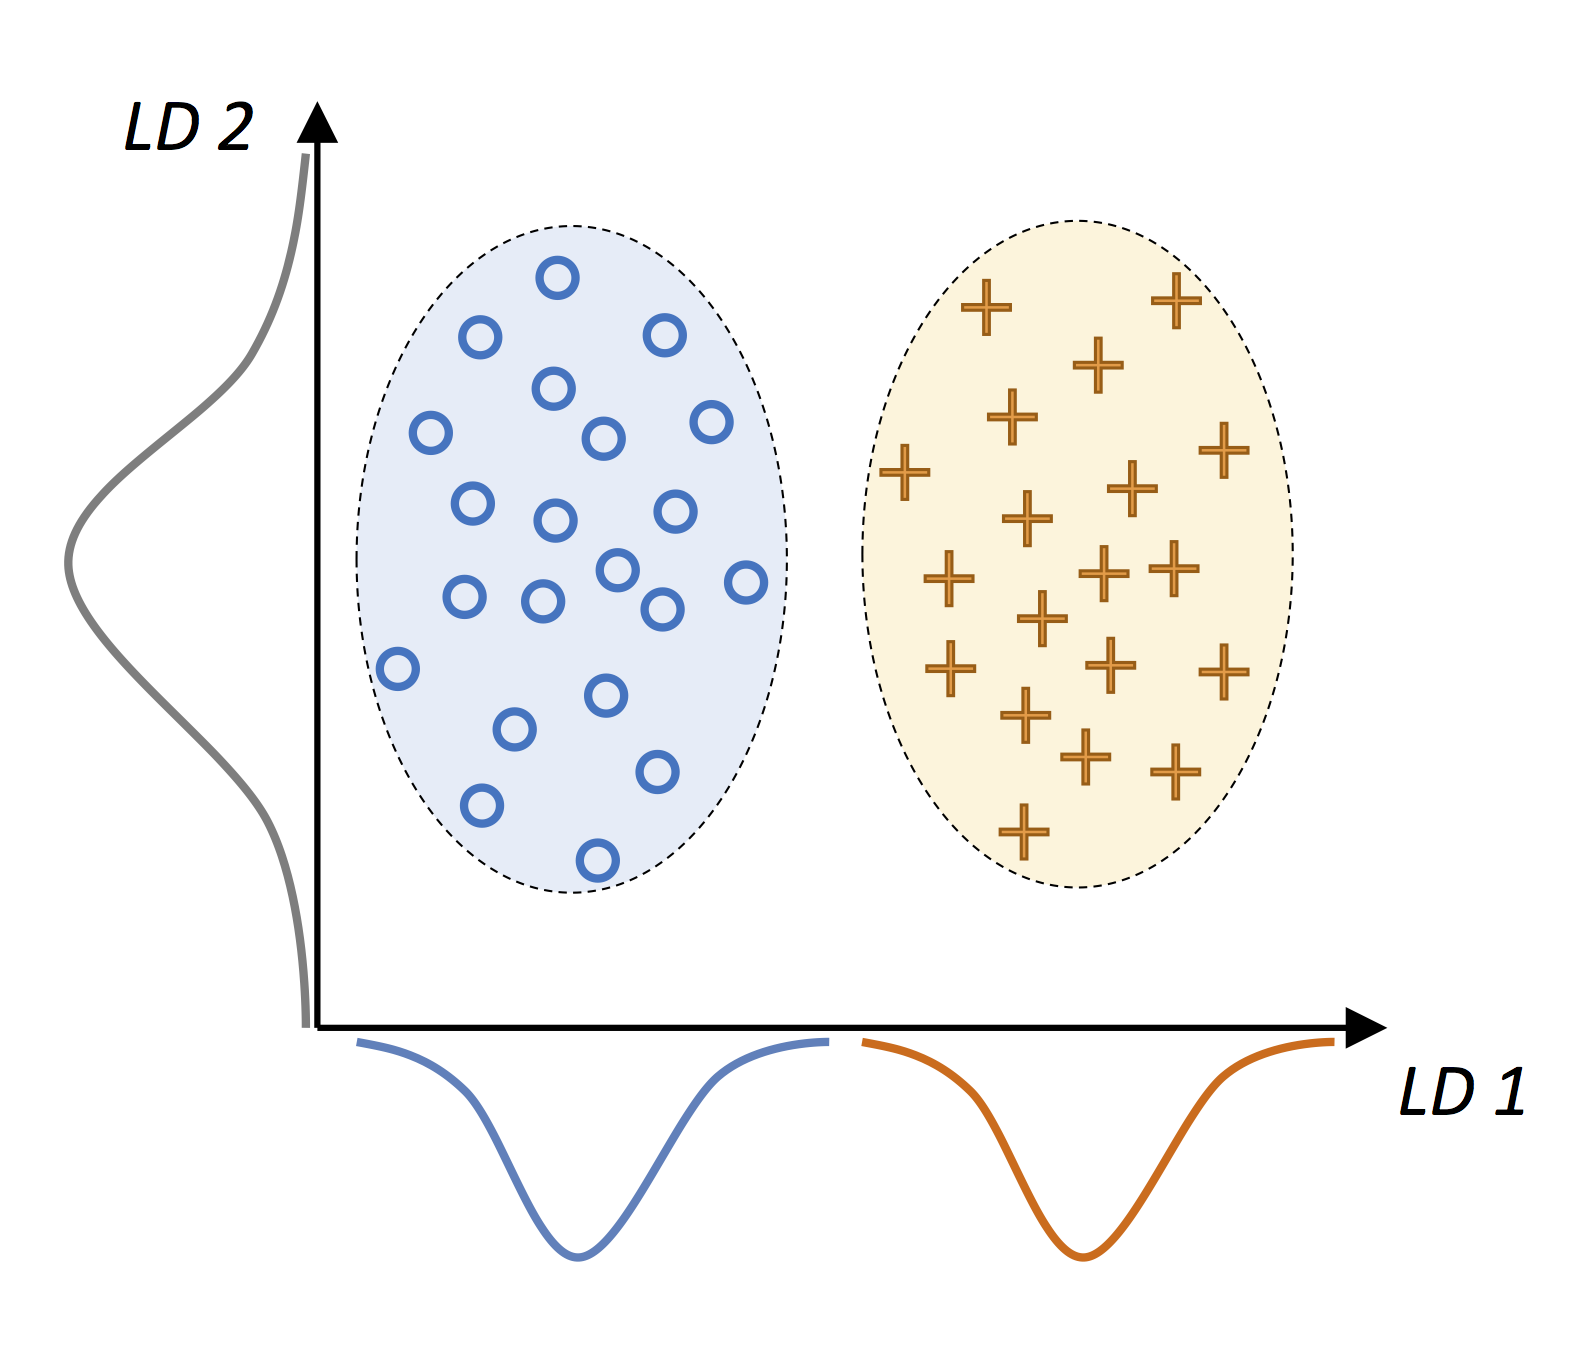

In [49]:
Image(filename='images/05_06.png', width=400) 

## 线性判别分析的内部工作原理

共线性

注意，在完全共线性的罕见情况下（所有同类的样本点都在一条直线上），协方差矩阵的秩为1，这将导致只有一个非零特征值的特征向量。要度量线性判别（特征向量）捕获了多少分类判别信息，我们可以通过降序的特征值画出线性判别图来展示，这与我们在PCA小节创建的解释方差图类似。为简单起见，我们将调用分类判别信息discriminability的内容：

## Computing the scatter matrices

Calculate the mean vectors for each class:

In [24]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Compute the within-class scatter matrix:

In [25]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


Better: covariance matrix since classes are not equally distributed:

In [26]:
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [27]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


Compute the between-class scatter matrix:

In [28]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


<br>
<br>

## Selecting linear discriminants for the new feature subspace

Solve the generalized eigenvalue problem for the matrix $S_W^{-1}S_B$:

In [29]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Note**:
    
Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


Sort eigenvectors in descending order of the eigenvalues:

In [30]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


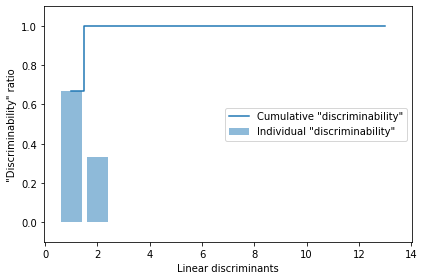

In [31]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_07.png', dpi=300)
plt.show()

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


<br>
<br>

## Projecting examples onto the new feature space

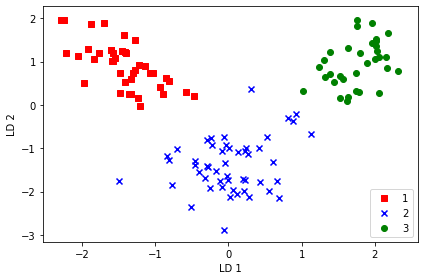

In [33]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/05_08.png', dpi=300)
plt.show()

<br>
<br>

## 用scikit-learn实现LDA

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

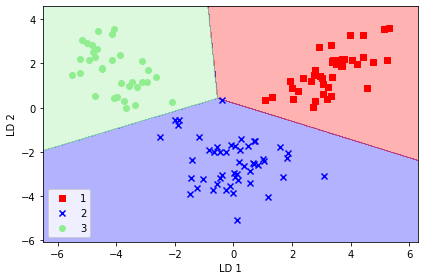

In [51]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_09.png', dpi=300)
plt.show()

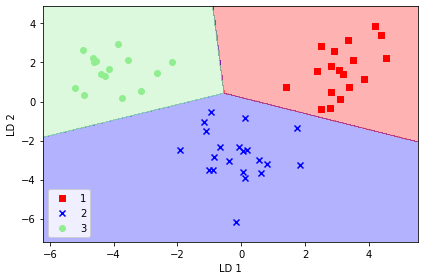

In [52]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_10.png', dpi=300)
plt.show()

# 非线性映射的核主成分分析

许多机器学习算法对输入数据的**线性可分性**做出假设。感知器甚至需要完全线性可分的训练数据才能收敛。对于目前所讨论过的诸如Adaline、逻辑回归和（标准）支持向量机等其他算法，我们假设缺乏完全线性可分性的原因是噪声。

然而，非线性问题在现实世界中层出不穷，如果我们所面对的是这类问题，那么像PCA和LDA这样的**线性变换降维技术**可能就不是最佳选择。

在本节中，我们将介绍与核支持向量机概念（第3章讨论过）相关的PCA的核化版本KPCA。利用KPCA，我们可以学习如何把线性不可分的数据转换到适合线性分类器的新的低维子空间

如果你是第一次接触“核”这个概念，可以先看看[这个](https://www.youtube.com/watch?v=vMmG_7JcfIc)[视频](https://www.bilibili.com/video/BV1UJ411U7Kc)

核函数不是一种函数，而是一类功能性函数，目的就是完成高维映射，具体完成两项工作，
- 一是增加空间的维度，
- 二是完成对现有数据从原空间到高维空间的映射。

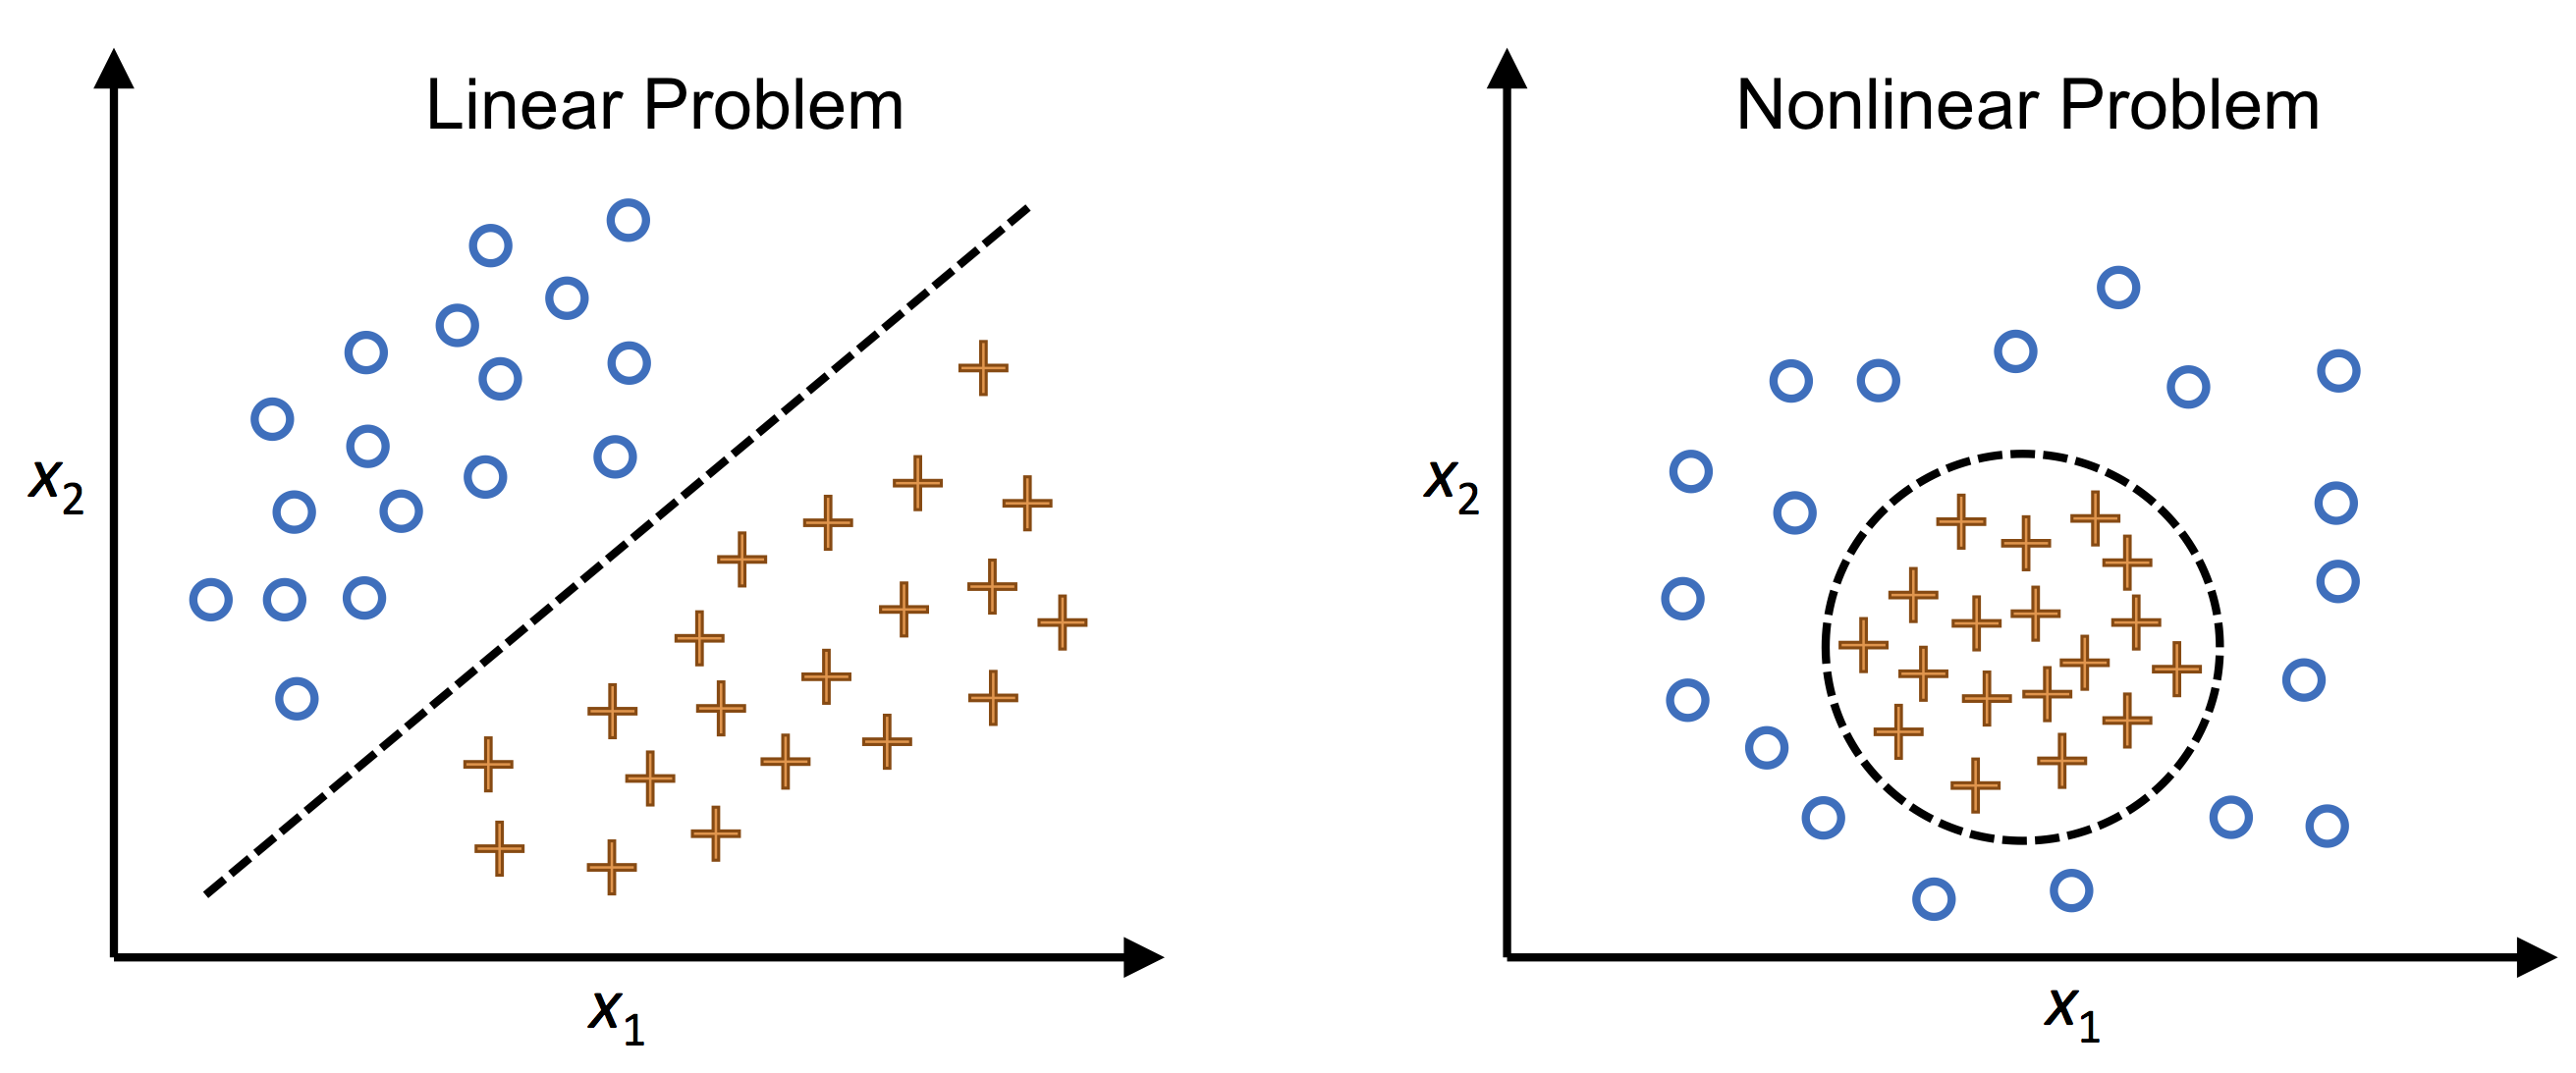

In [53]:
Image(filename='images/05_11.png', width=500) 

通过KPCA执行非线性映射将数据转换到高维空间。然后在这个高维空间用标准PCA将数据投影回低维空间，使其变为可用线性分类器分离（前提是在输入空间中样本可以通过密度进行分离）。然而，该方法的缺点是计算成本非常昂贵，而这正是核技巧发挥作用的地方。可以利用核技巧在原始特征空间计算两个高维特征向量之间的相似性。

## 用Python实现核主成分分析

In [54]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np


from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp




def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     X_pc: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset   

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

### 示例1——分离半月形

这两个半月形显然线性不可分，我们要通过核主成分分析来显示半月形，以便把数据集变成线性分类器的合适输入。

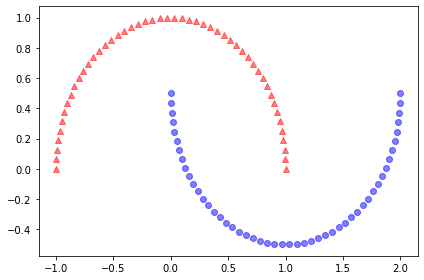

In [77]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_12.png', dpi=300)
plt.show()

但是我们要先观察通过标准的PCA把数据集投影到主成分上所带来的结果：

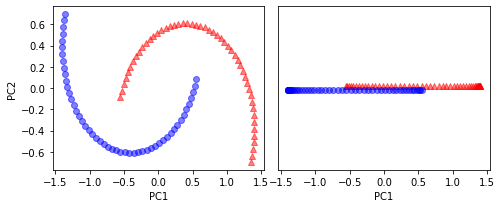

In [78]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_13.png', dpi=300)
plt.show()

明显可以看出线性分类器在标准PCA转换的数据集上表现不佳。

尝试使用上一小节实现的核主成分分析函数rbf_kernel_pca：

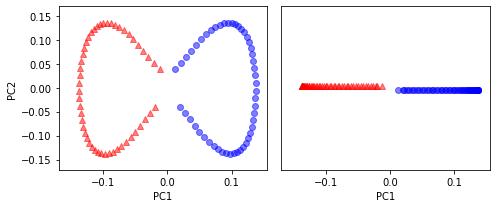

In [41]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_14.png', dpi=300)
plt.show()

可以看到圆形类和三角形类线性分离良好，这样我们就有了适合线性分类器的训练数据集。

### 示例2——分离同心圆

假设一个二元分类问题，三角形代表一类，而圆形代表另一类，如图所示。

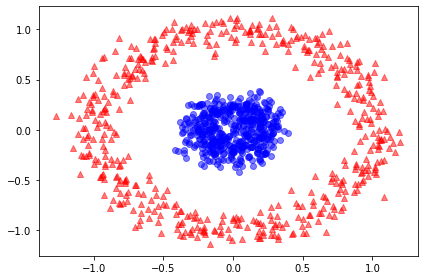

In [79]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('images/05_15.png', dpi=300)
plt.show()

从标准PCA方法开始，并与RBF核主成分分析的结果进行比较：

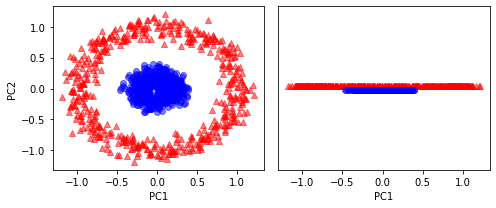

In [80]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_16.png', dpi=300)
plt.show()

标准PCA不能产生适合训练线性分类器的结果，如图所示。

用一个适当的γ值看能否幸运地用RBF KPCA实现完成任务：

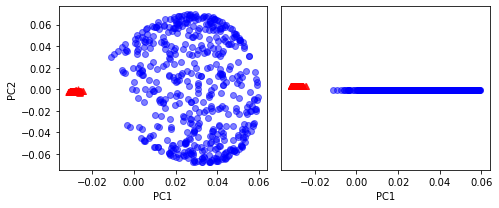

In [81]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_17.png', dpi=300)
plt.show()

RBF KPCA再次将数据投影到新的子空间，这两个类在该空间线性可分，如图所示。

## 投影新的数据点

在实际应用中，要转换的数据集可能不止一个，例如可能有训练和测试数据，通常还有模型构建和评估之后收集的新样本。

In [84]:
from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.

    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_examples, n_features]
        
    gamma: float
      Tuning parameter of the RBF kernel
        
    n_components: int
      Number of principal components to return

    Returns
    ------------
     alphas: {NumPy ndarray}, shape = [n_examples, k_features]
       Projected dataset 
     
     lambdas: list
       Eigenvalues

    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)

    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenpairs from the centered kernel matrix
    # scipy.linalg.eigh returns them in ascending order
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Collect the top k eigenvectors (projected examples)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # Collect the corresponding eigenvalues
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [85]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [86]:
x_new = X[25]
x_new

array([1.8713187 , 0.00928245])

In [87]:
x_proj = alphas[25] # original projection
x_proj

array([0.07877284])

In [88]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# projection of the "new" datapoint
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.07877284])

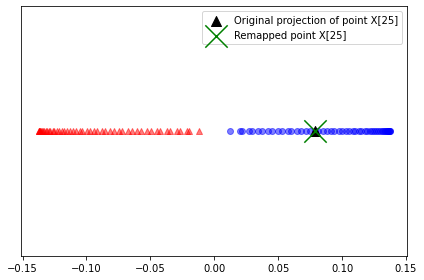

In [89]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='Original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='Remapped point X[25]', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('images/05_18.png', dpi=300)
plt.show()

## scikit-learn的核主成分分析

scikit-learn在sklearn.decomposition子模块中实现了KPCA类。用法类似于标准PCA类，可以通过kernel参数来指定核：

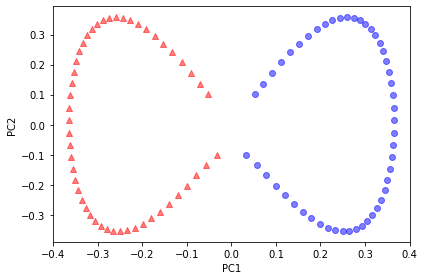

In [90]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()